# **IMAGE CLASSIFICATION USING CNN**
This notebook serves to illustrate strong performance by Convolutional Neural Networks (CNNs) in image classification. CNNs have done wonders for the field of computer vision by closely capturing this spatial hierarchy of images, hence it is excellent at extracting patterns or objects and features in an image. This notebook shows the basic steps to train and test a CNN model that classifies images in some category. In this notebook you will learn how CNNs work and how to use them for image classification tasks as long (that we hope!) at the end of it is presented what in your opinion should be a good accuracy.

## **About the Dataset**
The dataset consists of images of five famous wonders of the world, each labeled according to its name. The labels are:

1. **Burj Khalifa** - The tallest building in the world, located in Dubai, UAE. The images might include different angles and perspectives of this iconic skyscraper.

2. **Chichen Itza** - A large pre-Columbian archaeological site built by the Maya civilization, located in Mexico. Images may include various structures within the site, such as the El Castillo pyramid.

3. **Christ the Redeemer** - A colossal statue of Jesus Christ in Rio de Janeiro, Brazil. The dataset might include images from different viewpoints and distances.

4. **Eiffel Tower** - A wrought-iron lattice tower in Paris, France, known for its unique design. Images may vary in terms of lighting, angles, and seasonal changes.

5. **Great Wall of China** - A series of fortifications made of various materials that stretch across northern China. The images might showcase different sections of the wall.

Each category will have multiple images, which can be used to train and validate your CNN model for accurate classification. Make sure to preprocess the images (resize, normalize, etc.) to suit the input requirements of your model.

Here is a ste by ste guide to complete image classification using CNN.

# **IMPORT LIBRARIES**

In [349]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Flatten
from keras.optimizers import Adam

# **LOAD THE DATASET**
First we will load the dataset from the directory into a numpy array and assign label to each image.
Here how we can do that:



First we assign names to the types of wonders we aim to categorize and mention the location where the training images are saved.

**Categories:** We'll list out the labels that match up with the classifications of wonders. Each label is linked to a wonder of the world.

**Folder Location:** The path leading to the folder holding all the images. This pathway will be used to bring in the images, for our dataset.

In [333]:
labels = [ 'burj_khalifa', 'chichen_itza', 'christ_the_reedemer', 'machu_pichu', 'great_wall_of_china', 'statue_of_liberty']

train_dir = '/kaggle/input/wonders-of-the-world-image-classification/Wonders of World/Wonders of World'

Next we write a code to load all the images from the dataset directory.

- **Image Loading:** The function loops through each label and loads the images from the corresponding subdirectory.

- Each image is read using OpenCV’s `cv2.imread()`

- **Preprocess:** Convert BGR to RGB using `cv2.cvtColor()`.

- Resize to 32x32 using `cv2.resize()` to ensure all images are the same size.

- **Assign Label:** Assign each image to its corresponding label index (based on the position of the label in the labels list).

In [334]:
images = []
image_labels = []
for label in labels:
    label_dir = os.path.join(train_dir, label)
    image_files = glob.glob(os.path.join(label_dir, '*.jpg'))
        
    for image_file in image_files:
        # Load image using cv2
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Convert the image from BGR to RGB (if required)
        img = cv2.resize(img, (32, 32)) 
        # Append the image and its corresponding label
        images.append(np.array(img))
        image_labels.append(labels.index(label))
images = np.array(images)
image_labels = np.array(image_labels)

#### **Check the shape**

Now let's check the shape of the images and the labels to check if we have correctly loaded the images.

In [335]:
images.shape, image_labels.shape

((2076, 32, 32, 3), (2076,))

We can see that we have total 1446 images ehich have a 32 by 32 size.

# **VISUALIZE THE IMAGES**
Now let's visualize some images to get a better insight of our data.

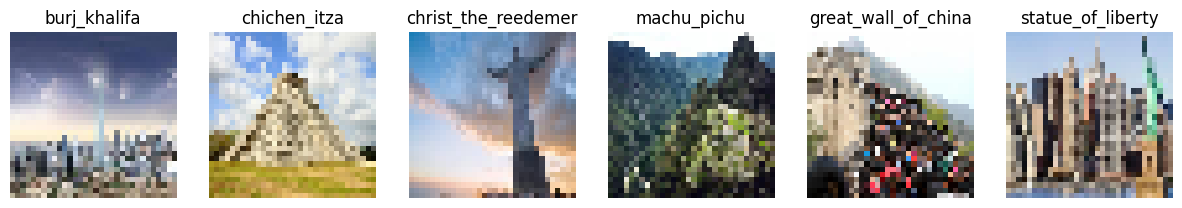

In [339]:
# Visualizing one image from each label
plt.figure(figsize=(15, 5))

for i, label in enumerate(labels):
    # Find the first image for the given label
    indices = np.where(image_labels == i)[0]
    
    index = indices[0]
    img = images[index]
        
    # Display the image
    plt.subplot(1, len(labels), i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()


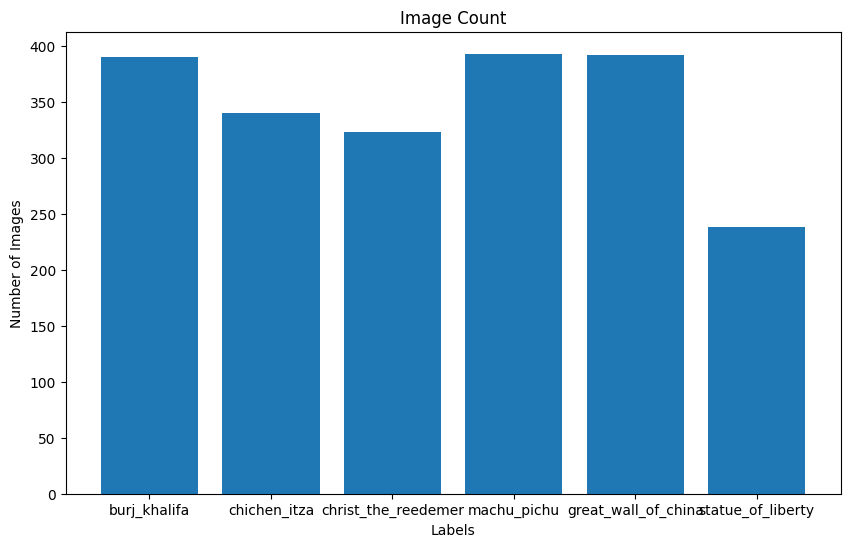

In [382]:
unique_labels, counts = np.unique(image_labels, return_counts = True)
# Plotting
plt.figure(figsize = (10, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Image Count')
plt.show()


# **TRAIN-TEST SPLIT**
Next we split our data into train and test sets,I am using 20% of my data for testing while remaining is for training.

In [341]:
train_images, test_images, train_labels, test_labels = train_test_split(images, image_labels, test_size = 0.2, random_state =42)

In [342]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((1660, 32, 32, 3), (416, 32, 32, 3), (1660,), (416,))

# **NORMALIZE THE IMAGES**
**1. Convert Data Type:** Convert the image data to float32 to ensure precision.

**2. Scale Pixel Values:** Divide pixel values by 255.0 to scale them to the range [0, 1].

In [343]:
# Normalize pixel values to be between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# **ONE-HOT ENCODING**

`to_categorical`: This function converts the integer labels into a binary matrix representation.

`num_classes`: The number of unique categories. In this example, it's set to 5 for the five wonders of the world. Adjust this value based on the actual number of categories in your dataset.

In [344]:
# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, 6)
test_labels = to_categorical(test_labels, 6)

In [345]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((1660, 32, 32, 3), (416, 32, 32, 3), (1660, 6), (416, 6))

# **DEFINE THE MODEL**
This section of the code defines and compiles a Convolutional Neural Network (CNN) model using the Keras `Sequential` API.

#### Model Architecture
1. **Convolutional Layer**
##### **Parameters:**
    - `85`: Number of filters in the convolutional layer.
    - `(3, 3)`: Size of the convolutional kernel.
    - `activation = 'relu'`: Activation function used to introduce non-linearity.
    - `input_shape = (32, 32, 3)`: Shape of the input images (32x32 pixels with 3 color channels).

2. **Pooling Layer**

`pool_size = (2, 2)`: Size of the pooling window.

3. **Flatten Layer**

Flattens the output of the convolutional layers to a 1D array to be fed into the fully connected layers.

4. **Fully Connected Layer**
##### **Parameters:**
    - `85`: Number of neurons in this layer.
    - `activation = 'relu'`: Activation function used to introduce non-linearity.
    
5. **Dropout Layer**
Reduces overfitting by randomly setting a fraction of input units to 0 during training.
##### **Parameters:**
`0.5`: Fraction of the input units to drop.

6. **Output Layer**
Produces the final classification probabilities.
##### **Parameters:**
`6`: Number of output units corresponding to the number of classes.
`activation = 'softmax'`: Activation function used to produce probabilities for each class.

In [346]:
model = Sequential()

# Convolutional Layer
model.add(Conv2D(85, (3, 3), activation = 'relu', input_shape = (32, 32, 3)))

# Pooling Layer
model.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(85, activation = 'relu'))

# Drop-out Layer (to avoid overfitting)
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(6, activation = 'softmax'))  # Number of classes is 5



# **COMPILE THE MODEL**
Next we compile our model.
- **Optimizer**: `Adam` with a learning rate of 0.0003 is used for training the model.
- **Loss Function**: `categorical_crossentropy` is used for multi-class classification problems.
- **Metrics**: `accuracy` is used to evaluate the performance of the model.

In [347]:
# Compile the model
model.compile(optimizer = Adam(learning_rate = 0.0003),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_106 (Conv2D)             │ (None, 30, 30, 85)     │         2,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 15, 15, 85)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_78 (Flatten)            │ (None, 19125)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 85)             │     1,625,710 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 85)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 6)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,606 (6.21 MB)

 Trainable params: 1,628,606 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

# **FIT THE MODEL**
Now we train the model using the training data, I am using the testing data as validation data so that we can see the model performane during each epoch.

1. `batch_size = 64`: A batch size of 64 means the model will process 64 images before updating the weights.

2. `epochs = 50`: In this case, the model will go through 50 iterations of the training data.

3. `validation_data = (test_images, test_labels)`: The data on which the model is evaluated after each epoch.

4. `shuffle = True`: Shuffles the training data before each epoch. This helps to improve the model’s generalization by presenting the data in a different order.

In [348]:
# Fit the model
history = model.fit(train_images, train_labels,
                    batch_size = 64,
                    epochs = 50,
                    validation_data = (test_images, test_labels),
                    shuffle = True)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.2323 - loss: 1.7736 - val_accuracy: 0.4375 - val_loss: 1.5602
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3904 - loss: 1.5529 - val_accuracy: 0.4471 - val_loss: 1.4110
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4221 - loss: 1.4599 - val_accuracy: 0.5168 - val_loss: 1.3005
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4847 - loss: 1.3106 - val_accuracy: 0.5938 - val_loss: 1.1955
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5411 - loss: 1.2083 - val_accuracy: 0.5312 - val_loss: 1.1792
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5292 - loss: 1.1930 - val_accuracy: 0.5841 - val_loss: 1.1184
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5454 - loss: 1.1727 - val_accuracy: 0.6442 - val_loss: 1.0684
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5882 - loss: 1.0782 - val_accuracy: 0.6250 - v

# **EVALUATE THE MODEL**
Now that we have trained our model now we evalute it first we print the confusion matrix to check the true positive rate.

## **CONFUSION MATRIX**

First get the predictions for the test_data.

In [351]:
predictions = model.predict(test_images)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Next we convert one-hot encoded predictions to class labels

In [352]:
predicted_classes = np.argmax(predictions, axis=1)

Convert one-hot encoded test labels to class labels

In [353]:
true_classes = np.argmax(test_labels, axis=1)

In [354]:
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

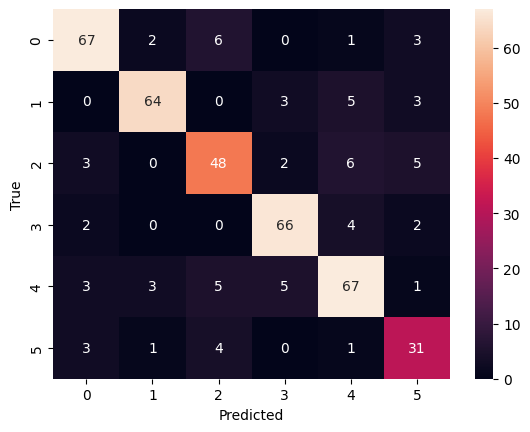

In [361]:
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# **ROC CURVE**
ROC curve plot evaluates the performance of a multi-class classification model, showing that the model performs quite well across all six classes, as indicated by the high AUC values.

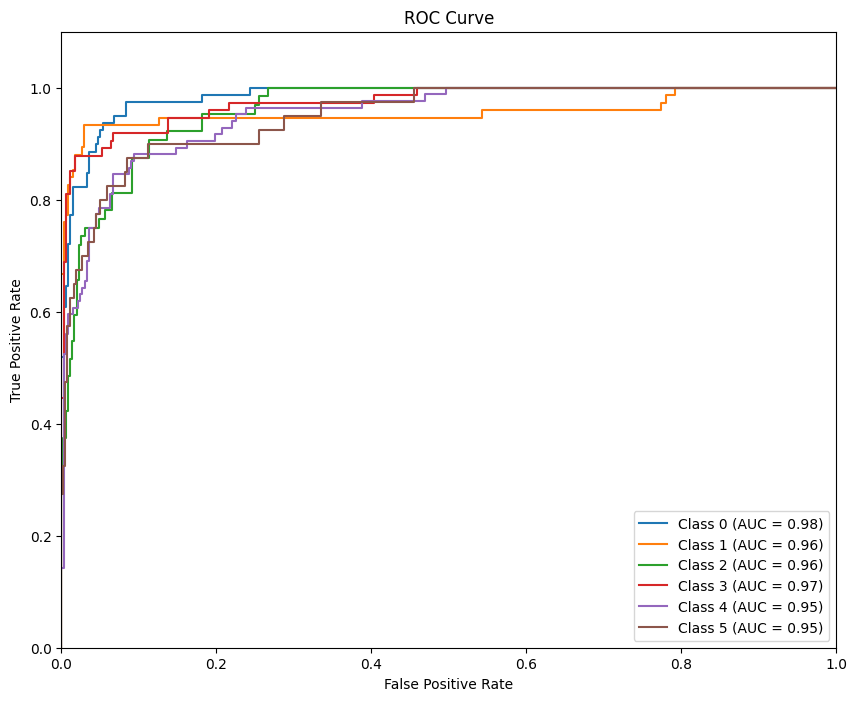

In [380]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
roc_auc = {}

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(6):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

#plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()


# **PLOT LOSS AND ACCURACY CURVE**
To get a better idea of how our model has performed we can plot a loss and accuracy vs epochs curve to check whether the model is underfit, goodfit or overfit.

In [362]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

13/13 - 0s - 8ms/step - accuracy: 0.8245 - loss: 0.5775


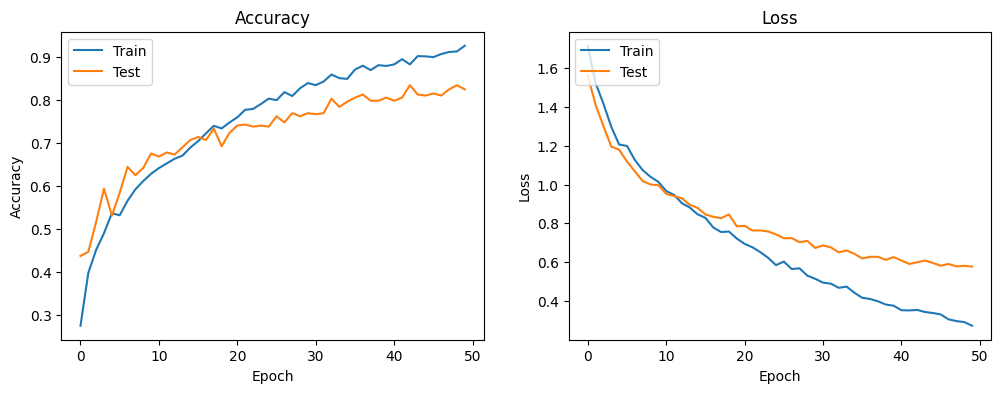

In [365]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

We can also save the results of our predictions data in a dataframe.

In [369]:
predictions_df = pd.DataFrame({'Actual Label': true_classes,'Predicted Label': predicted_classes})


In [372]:
results_df

,Actual Label,Predicted Label
0,0,0
1,3,3
2,2,2
3,0,0
4,2,2
...,...,...
411,2,2
412,0,0
413,1,1
414,4,4


# **SAVE THE MODEL**

In [373]:
# Save the entire model to a file
model.save('cnn_model.h5')